In [1]:
import os, sys
import numpy as np
import scipy
#import scipy.spatial
import matplotlib.pyplot as plt
import IPython.display as ipd
import librosa, librosa.display
#from matplotlib import gridspec
from numba import jit
from IPython.display import Audio

sys.path.append('..')
import libfmp.b
import libfmp.c2
import libfmp.c6
%matplotlib inline

@jit(nopython=True)
def nmf(V, R, thresh=0.001, L=1000, W=None, H=None, norm=False, report=False):
    """NMF algorithm with Euclidean distance

    Notebook: C8/C8S3_NMFbasic.ipynb

    Args:
        V (np.ndarray): Nonnegative matrix of size K x N
        R (int): Rank parameter
        thresh (float): Threshold used as stop criterion (Default value = 0.001)
        L (int): Maximal number of iteration (Default value = 1000)
        W (np.ndarray): Nonnegative matrix of size K x R used for initialization (Default value = None)
        H (np.ndarray): Nonnegative matrix of size R x N used for initialization (Default value = None)
        norm (bool): Applies max-normalization of columns of final W (Default value = False)
        report (bool): Reports errors during runtime (Default value = False)

    Returns:
        W (np.ndarray): Nonnegative matrix of size K x R
        H (np.ndarray): Nonnegative matrix of size R x N
        V_approx (np.ndarray): Nonnegative matrix W*H of size K x N
        V_approx_err (float): Error between V and V_approx
        H_W_error (np.ndarray): History of errors of subsequent H and W matrices
    """
    K = V.shape[0]
    N = V.shape[1]
    if W is None:
        W = np.random.rand(K, R)
    if H is None:
        H = np.random.rand(R, N)
    V = V.astype(np.float64)
    W = W.astype(np.float64)
    H = H.astype(np.float64)
    H_W_error = np.zeros((2, L))
    ell = 1
    below_thresh = False
    eps_machine = np.finfo(np.float32).eps
    while not below_thresh and ell <= L:
        H_ell = H
        W_ell = W
        H = H * (W.transpose().dot(V) / (W.transpose().dot(W).dot(H) + eps_machine))
        W = W * (V.dot(H.transpose()) / (W.dot(H).dot(H.transpose()) + eps_machine))

        # H+1 = H *p ((W^T * V) / p (W^T * W * H))
        # H = np.multiply(H, np.divide(np.matmul(np.transpose(W), V),
        #                              np.matmul(np.matmul(np.transpose(W), W), H)))
        # W+1 = W *p ((V * H^T) / p (W * H * H^T))
        # W = np.multiply(W, np.divide(np.matmul(V, np.transpose(H)),
        #                              np.matmul(np.matmul(W, H), np.transpose(H))))

        H_error = np.linalg.norm(H-H_ell, ord=2)
        W_error = np.linalg.norm(W - W_ell, ord=2)
        H_W_error[:, ell-1] = [H_error, W_error]
        if report:
            print('Iteration: ', ell, ', H_error: ', H_error, ', W_error: ', W_error)
        if H_error < thresh and W_error < thresh:
            below_thresh = True
            H_W_error = H_W_error[:, 0:ell]
        ell += 1
    if norm:
        for r in range(R):
            v_max = np.max(W[:, r])
            if v_max > 0:
                W[:, r] = W[:, r] / v_max
                H[r, :] = H[r, :] * v_max
    V_approx = W.dot(H)
    V_approx_err = np.linalg.norm(V-V_approx, ord=2)
    return W, H, V_approx, V_approx_err, H_W_error

Matrix V and randomly initialized matrices W and H


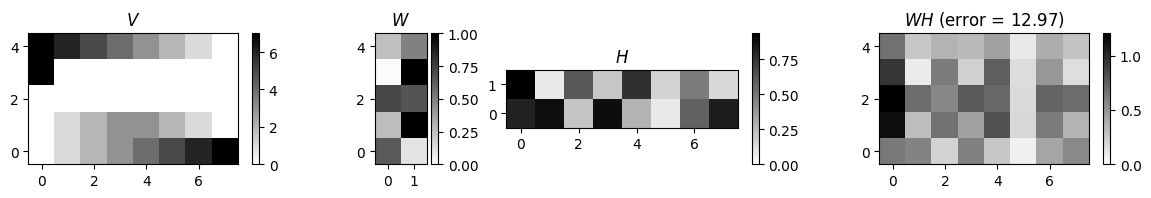

Matrix V and matrices W and H after training


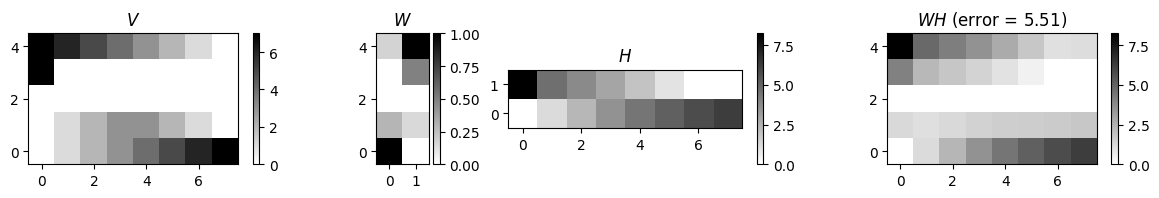

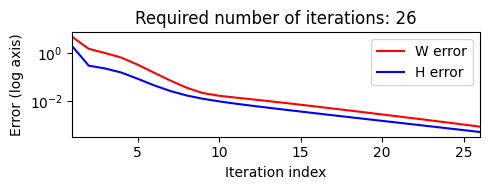

In [2]:
 def plot_nmf(V, W, H, V_approx, error, figsize=(10,2), aspect='auto', wr=[1, 0.5, 1, 1]): 
    fig, ax = plt.subplots(1, 4, gridspec_kw={'width_ratios': wr},
                           figsize=figsize)    
    cmap = 'gray_r'
    # im = ax[0].imshow(V, aspect=aspect, origin='lower', cmap=cmap, clim=[0, np.max(V)])
    im = ax[0].imshow(V, aspect=aspect, origin='lower', cmap=cmap)
    ax[0].set_title(r'$V$')
    plt.sca(ax[0])
    plt.colorbar(im)   
    im = ax[1].imshow(W, aspect=aspect, origin='lower', cmap=cmap, clim=[0, np.max(W)])
    ax[1].set_title(r'$W$')
    plt.sca(ax[1])
    plt.colorbar(im)
    im = ax[2].imshow(H, aspect=aspect, origin='lower', cmap=cmap, clim=[0, np.max(H)])
    ax[2].set_title(r'$H$')
    plt.sca(ax[2])    
    plt.colorbar(im)
    im = ax[3].imshow(V_approx, aspect=aspect, origin='lower', cmap=cmap, clim=[0, np.max(V_approx)])
    ax[3].set_title(r'$WH$ (error = %0.2f)'%error)
    plt.sca(ax[3])    
    plt.colorbar(im)
    plt.tight_layout() 
    plt.show() 
    
# V = np.array([ 
#     [0, 1, 2, 3, 4, 5, 6, 7], 
#     [0, 1, 2, 3, 3, 2, 1, 0],
#     [0, 0, 0, 0, 0, 0, 0, 0], 
#     [7, 0, 0, 0, 0, 0, 0, 0], 
#     [7, 6, 5, 4, 3, 2, 1, 0]    
#              ],dtype=float)
# 
# K = V.shape[0]
# N = V.shape[1]
# R = 2
# thresh = 0.001
# L = 100
# 
# W_init =  np.random.rand(K,R) 
# W_init = W_init/np.max(W_init)
# H_init = np.random.rand(R,N)    
# 
# print('Matrix V and randomly initialized matrices W and H')
# V_approx = W_init.dot(H_init)
# error = np.linalg.norm(V-V_approx, ord=2)
# plot_nmf(V, W_init, H_init, V_approx, error, figsize=(12,2), 
#          aspect='equal', wr=[1, 0.3, 1, 1])
# 
# print('Matrix V and matrices W and H after training')
# W, H, V_approx, V_approx_err, H_W_error = nmf(V, R, thresh=thresh, 
#                                    L=L, W=W_init, H=H_init, norm=1, report=0)
# plot_nmf(V, W, H, V_approx, V_approx_err, figsize=(12,2), 
#          aspect='equal', wr=[1, 0.3, 1, 1])
# 
# plt.figure(figsize=(5,2))
# num_iter = H_W_error.shape[1]
# plt.plot(np.arange(num_iter)+1, H_W_error[0,:], 'r', label='W error')
# plt.plot(np.arange(num_iter)+1, H_W_error[1,:], 'b', label='H error')
# plt.yscale('log')
# plt.xlabel('Iteration index')
# plt.ylabel('Error (log axis)')
# plt.title('Required number of iterations: %d'%num_iter)
# plt.xlim([1, num_iter])
# plt.legend()
# plt.tight_layout()

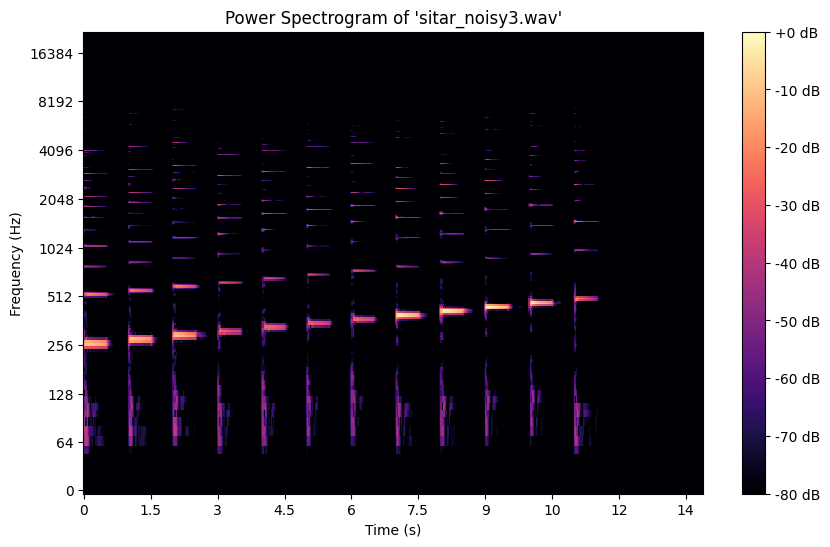

In [42]:
sitar_path = "audio_files/sitar_notes.wav"
piano_path = "audio_files/music_notes.wav"
x, Fs = librosa.load(piano_path, sr=None)
# x, Fs = librosa.load(piano_path, sr=None)
# Audio(x, rate=Fs)
N = 2048 * 2
H = N // 4
hop = H
n_fft = N

X = librosa.stft(x, n_fft=N, hop_length=H, win_length=N, window='hann', pad_mode='constant')
Y = np.abs(X) ** 2

plt.figure(figsize=(10, 6))
librosa.display.specshow(librosa.amplitude_to_db(Y, ref=np.max),
                         sr=Fs, hop_length=H, x_axis='time', y_axis='log', cmap='magma')
plt.colorbar(format="%+2.0f dB")
plt.title("Power Spectrogram of 'sitar_noisy3.wav'")
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.show()

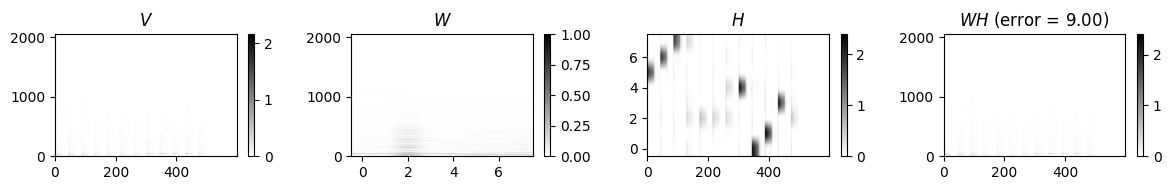

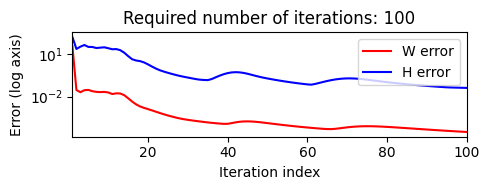

In [47]:
V = np.log(1 + np.abs(X))
K = V.shape[0]
N = V.shape[1]
R = 8
thresh = 0.001
L = 100

W_init =  np.random.rand(K,R) 
W_init = W_init/np.max(W_init)
H_init = np.random.rand(R,N) 

V_approx = W_init.dot(H_init)
error = np.linalg.norm(V-V_approx, ord=2)
W, H, V_approx, V_approx_err, H_W_error = nmf(V, R, thresh=thresh, 
                                   L=L, W=W_init, H=H_init, norm=1, report=0)

plot_nmf(V, W, H, V_approx, V_approx_err, figsize=(12,2), 
         aspect='auto', wr=[1, 1, 1, 1])

plt.figure(figsize=(5,2))
num_iter = H_W_error.shape[1]
plt.plot(np.arange(num_iter)+1, H_W_error[0,:], 'r', label='W error')
plt.plot(np.arange(num_iter)+1, H_W_error[1,:], 'b', label='H error')
plt.yscale('log')
plt.xlabel('Iteration index')
plt.ylabel('Error (log axis)')
plt.title('Required number of iterations: %d'%num_iter)
plt.xlim([1, num_iter])
plt.legend()
plt.tight_layout()

In [51]:
# post processing

threshold = 0.01 * np.max(H)
note_activations = H > threshold  # Binary thresholding for note onset detection

# Example: Map frequency bins in W to musical pitches
frequencies = librosa.fft_frequencies(sr=Fs, n_fft=n_fft)
pitches = librosa.hz_to_midi(frequencies)

# Map the most prominent frequency of each component in W to a pitch
note_pitches = []
for r in range(R):
    dominant_freq_bin = np.argmax(W[:, r])  # Find max frequency bin in the component
    # print(dominant_freq_bin)
    note_pitches.append(pitches[dominant_freq_bin])

print("Detected Notes (MIDI numbers):", note_pitches)

Detected Notes (MIDI numbers): [np.float64(68.190402488038), np.float64(69.05619991710802), np.float64(64.21593158633351), np.float64(69.8807529181162), np.float64(66.80467587899876), np.float64(59.78512587034489), np.float64(61.17085247938413), np.float64(61.82422588765264)]


In [52]:
W.shape
len(frequencies)
# n_fft

2049

In [53]:
note_names = ["C", "C#", "D", "D#", "E", "F", "F#", "G", "G#", "A", "A#", "B"]
notes = []

# Convert MIDI numbers to notes
for midi in note_pitches:
    midi_rounded = round(midi)  # Round to nearest integer
    note = note_names[midi_rounded % 12]  # Note name
    octave = (midi_rounded // 12) - 1  # Octave calculation
    notes.append(f"{note}{octave}")

print("Detected Notes:", notes)

Detected Notes: ['G#4', 'A4', 'E4', 'A#4', 'G4', 'C4', 'C#4', 'D4']


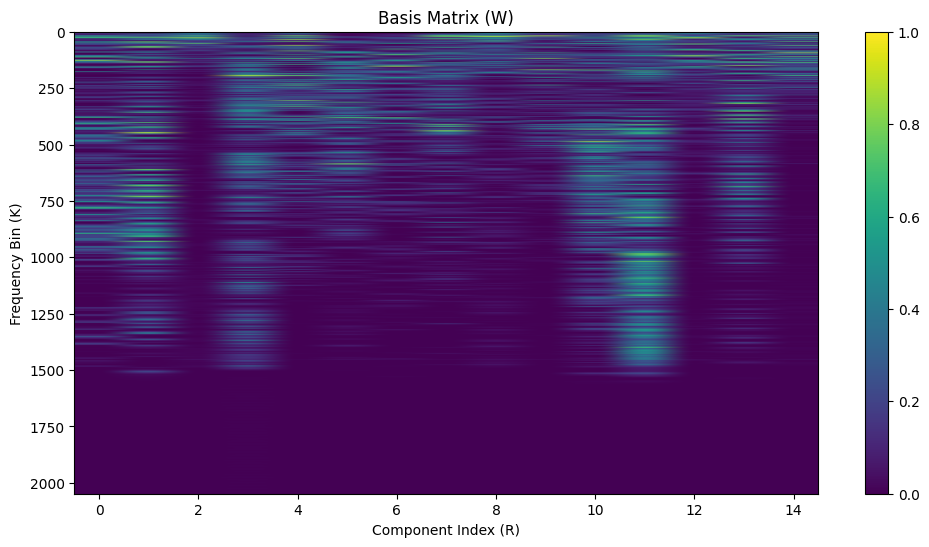

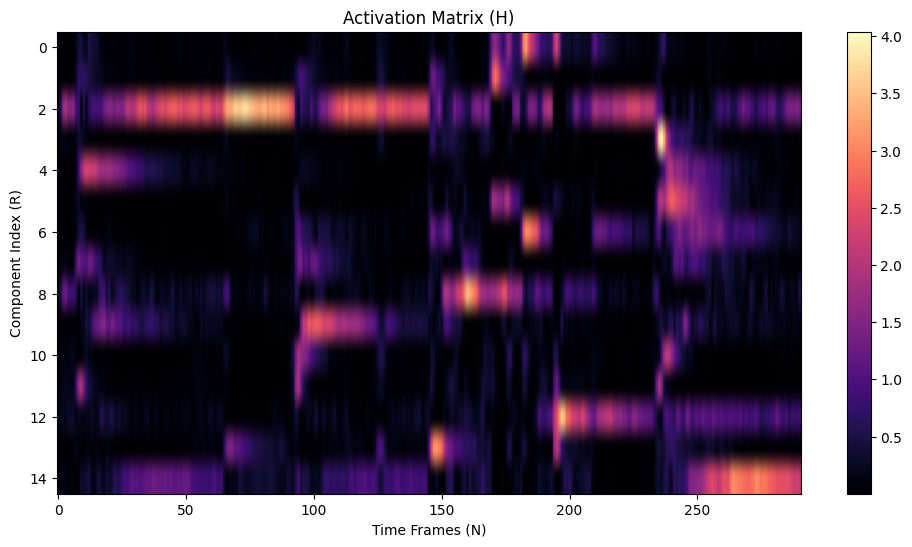

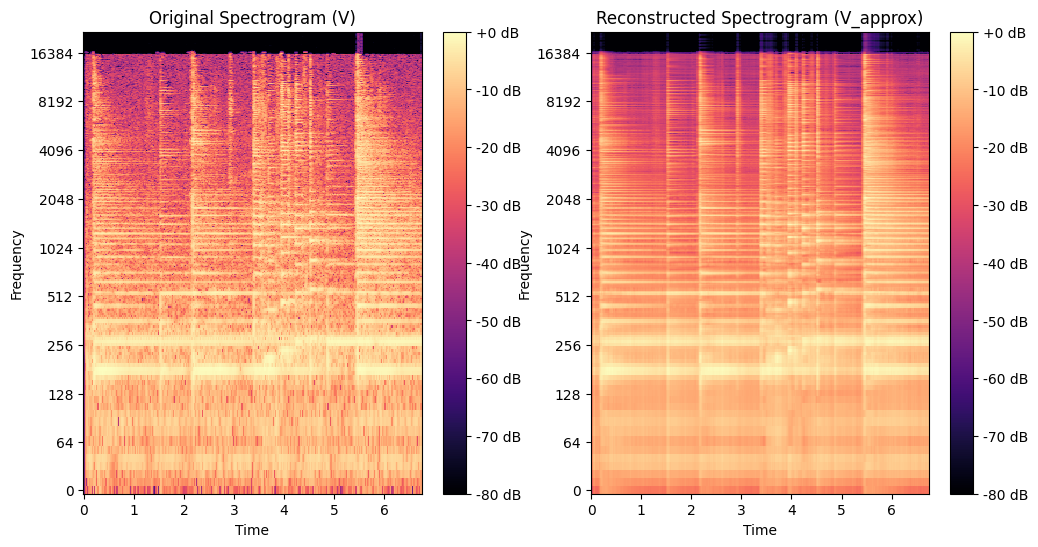

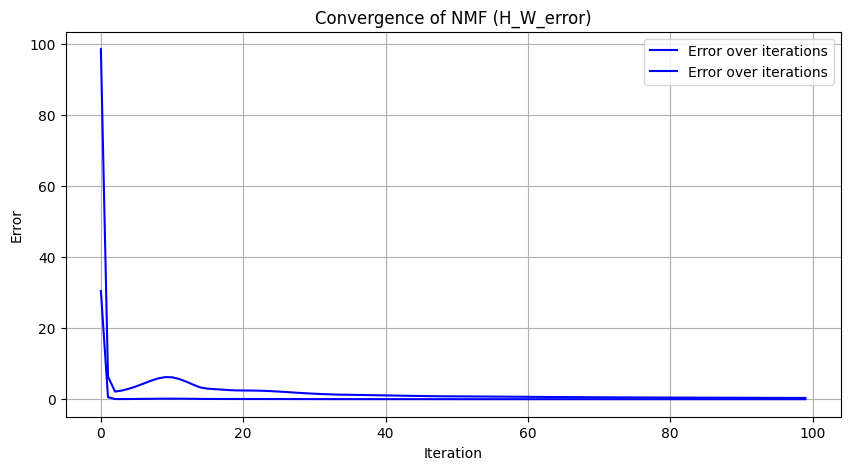

In [113]:
# 1. Visualize W (basis matrix)
plt.figure(figsize=(12, 6))
plt.imshow(W, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title('Basis Matrix (W)')
plt.xlabel('Component Index (R)')
plt.ylabel('Frequency Bin (K)')
plt.show()

# 2. Visualize H (activation matrix)
plt.figure(figsize=(12, 6))
plt.imshow(H, aspect='auto', cmap='magma')
plt.colorbar()
plt.title('Activation Matrix (H)')
plt.xlabel('Time Frames (N)')
plt.ylabel('Component Index (R)')
plt.show()

# 3. Compare V and V_approx
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
librosa.display.specshow(librosa.amplitude_to_db(V, ref=np.max), sr=Fs, hop_length=hop, x_axis='time', y_axis='log', cmap='magma')
plt.colorbar(format="%+2.0f dB")
plt.title('Original Spectrogram (V)')
plt.xlabel('Time')
plt.ylabel('Frequency')
# 
plt.subplot(1, 2, 2)
librosa.display.specshow(librosa.amplitude_to_db(V_approx, ref=np.max), sr=Fs, hop_length=hop, x_axis='time', y_axis='log', cmap='magma')
plt.colorbar(format="%+2.0f dB")
plt.title('Reconstructed Spectrogram (V_approx)')
plt.xlabel('Time')
plt.ylabel('Frequency')
plt.show()

# 4. Visualize the reconstruction error (V_approx_err)
# plt.figure(figsize=(12, 6))
# librosa.display.specshow(librosa.amplitude_to_db(V_approx_err, ref=np.max), cmap='coolwarm', aspect='auto')
# plt.colorbar(format="%+2.0f dB")
# plt.title('Approximation Error (V_approx_err)')
# plt.xlabel('Time')
# plt.ylabel('Frequency')
# plt.show()

# 5. Plot convergence (H_W_error)
plt.figure(figsize=(10, 5))
plt.plot(H_W_error.T, label='Error over iterations', color='blue')
plt.title('Convergence of NMF (H_W_error)')
plt.xlabel('Iteration')
plt.ylabel('Error')
plt.legend()
plt.grid(True)
plt.show()